In [ ]:
import os
import pickle
from tqdm.notebook import tqdm

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from tensorflow.keras.applications.densenet import DenseNet201, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [ ]:
!pip install opendatasets
!pip install pandas

In [ ]:
import opendatasets as od
import pandas

In [ ]:
# od.download("https://www.kaggle.com/datasets/saifsust/bancap/data")

In [ ]:
od.download("https://www.kaggle.com/datasets/adityajn105/flickr8k/data")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: sayemaamin200041234
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/adityajn105/flickr8k


100%|██████████| 1.04G/1.04G [00:07<00:00, 149MB/s]


In [ ]:
BASE_DIR = '/content/flickr8k'

In [ ]:
image_path = "/content/flickr8k/Images"
data = pd.read_csv("/content/flickr8k/bancap.csv")
jpgs = os.listdir(image_path)
print("Total Images in Dataset = {}".format(len(jpgs)))
print(type(data))
data

Total Images in Dataset = 8091
<class 'pandas.core.frame.DataFrame'>


image  repeat  \
0      1000268201_693b08cb0e.jpg       0   
1      1000268201_693b08cb0e.jpg       1   
2      1000268201_693b08cb0e.jpg       2   
3      1000268201_693b08cb0e.jpg       3   
4      1000268201_693b08cb0e.jpg       4   
...                          ...     ...   
40450   997722733_0cb5439472.jpg       0   
40451   997722733_0cb5439472.jpg       1   
40452   997722733_0cb5439472.jpg       2   
40453   997722733_0cb5439472.jpg       3   
40454   997722733_0cb5439472.jpg       4   

                                         english_caption  \
0      A child in a pink dress is climbing up a set o...   
1                  A girl going into a wooden building .   
2       A little girl climbing into a wooden playhouse .   
3      A little girl climbing the stairs to her playh...   
4      A little girl in a pink dress going into a woo...   
...                                                  ...   
40450           A man in a pink shirt climbs a rock face   
40451           A man is rock climbing high in the air .   
40452  A person in a red shirt climbing up a rock fac...   
40453                    A rock climber in a red shirt .   
40454  A rock climber practices on a rock climbing wa...   

                                                 caption  
0      একটি গোলাপী জামা পরা বাচ্চা মেয়ে একটি বাড়ির প্...  
1                 একটি মেয়ে শিশু একটি কাঠের বাড়িতে ঢুকছে  
2                    একটি বাচ্চা তার কাঠের খেলাঘরে উঠছে   
3               ছোট মেয়েটি তার খেলার ঘরের সিড়ি বেয়ে উঠছে  
4      গোলাপি জামা পড়া ছোট একটি মেয়ে একটি কাঠের তৈরি...  
...                                                  ...  
40450     গোলাপী শার্টের একটি লোক একটি শিলার উপরে উঠেছিল  
40451                    একজন মানুষ পাথরে চড়ছে অনেক উপরে  
40452  লাল শার্টের একজন ব্যক্তি সহায়তার হাতলগুলিতে ঢ...  
40453                           লাল শার্টে একটি রক আরোহী  
40454  একটি রক আরোহী একটি শৈল আরোহণ প্রাচীর এর উপর অন...  

[40455 rows x 4 columns]

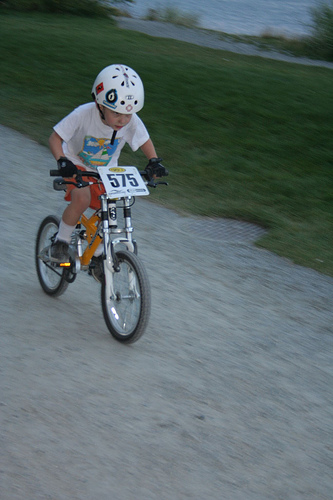

In [ ]:
from IPython.display import Image
Image('/content/flickr8k/Images/1075716537_62105738b4.jpg')

In [ ]:
# data['caption_id']=data['caption_id'].str[:-2]

In [ ]:
# data['caption_id']

In [ ]:
data=data.drop('english_caption',axis=1)

In [ ]:
data.rename(columns = {'caption_id':'image','bengali_caption':'caption'}, inplace = True)

In [ ]:
data

image  repeat  \
0      1000268201_693b08cb0e.jpg       0   
1      1000268201_693b08cb0e.jpg       1   
2      1000268201_693b08cb0e.jpg       2   
3      1000268201_693b08cb0e.jpg       3   
4      1000268201_693b08cb0e.jpg       4   
...                          ...     ...   
40450   997722733_0cb5439472.jpg       0   
40451   997722733_0cb5439472.jpg       1   
40452   997722733_0cb5439472.jpg       2   
40453   997722733_0cb5439472.jpg       3   
40454   997722733_0cb5439472.jpg       4   

                                                 caption  
0      একটি গোলাপী জামা পরা বাচ্চা মেয়ে একটি বাড়ির প্...  
1                 একটি মেয়ে শিশু একটি কাঠের বাড়িতে ঢুকছে  
2                    একটি বাচ্চা তার কাঠের খেলাঘরে উঠছে   
3               ছোট মেয়েটি তার খেলার ঘরের সিড়ি বেয়ে উঠছে  
4      গোলাপি জামা পড়া ছোট একটি মেয়ে একটি কাঠের তৈরি...  
...                                                  ...  
40450     গোলাপী শার্টের একটি লোক একটি শিলার উপরে উঠেছিল  
40451                    একজন মানুষ পাথরে চড়ছে অনেক উপরে  
40452  লাল শার্টের একজন ব্যক্তি সহায়তার হাতলগুলিতে ঢ...  
40453                           লাল শার্টে একটি রক আরোহী  
40454  একটি রক আরোহী একটি শৈল আরোহণ প্রাচীর এর উপর অন...  

[40455 rows x 3 columns]

In [ ]:
# # load vgg16 model
# model = VGG16()
# # restructure the model
# model = Model(inputs = model.inputs, outputs = model.layers[-2].output)
# # summarize
# print(model.summary())

In [ ]:
model = DenseNet201(weights="imagenet", input_shape=(224,224,3))
model.summary()

82524592/82524592 [==============================] - 1s 0us/step
Model: "densenet201"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormali

In [ ]:
# Create a new model, by removing the last layer (output layer of 1000 classes) from the resnet50
model_new = Model(model.input, model.layers[-2].output)

In [ ]:
# extract features from image
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    #load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size = (224, 224))
    # convert img pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    feature = model_new.predict(image, verbose = 0)
    # get image id
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [ ]:
# def preprocess_image(img):
#     img = image.load_img(img, target_size=(224,224))
#     img = image.img_to_array(img)
#     img = np.expand_dims(img, axis=0)
#     img = preprocess_input(img)
#     return img

In [ ]:
# def encode_image(img):
#     img = preprocess_image(img)
#     feature_vector = model_new.predict(img)
#     feature_vector = feature_vector.reshape(feature_vector.shape[1],)
#     return feature_vector

In [ ]:
# from time import time

In [ ]:
# start = time()

# features = {}

# directory = os.path.join(BASE_DIR, 'Images')

# for ix, img in tqdm(os.listdir(directory)):

#     img = "./flicker8k-dataset/Flickr8k_Dataset/{}.jpg".format(train[ix])
#     encoding_train[img[len(images):]] = encode_image(img)

#     if ix%100==0:
#         print("Encoding image- "+ str(ix))

# print("Time taken in seconds =", time()-start)

In [ ]:
WORKING_DIR = '/content/working/'
if not os.path.exists(WORKING_DIR):
    os.makedirs(WORKING_DIR)
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [ ]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [ ]:
BANCAP_DIR = '/content/flickr8k'
if not os.path.exists(BANCAP_DIR):
    os.makedirs(BANCAP_DIR)
with open(os.path.join(BANCAP_DIR, 'bancap.csv'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [ ]:
captions_doc

'1000268201_693b08cb0e.jpg,0,A child in a pink dress is climbing up a set of stairs in an entry way .,একটি গোলাপী জামা পরা বাচ্চা মেয়ে একটি বাড়ির প্রবেশ পথের সিঁড়ি বেয়ে উঠছে\n1000268201_693b08cb0e.jpg,1,A girl going into a wooden building .,একটি মেয়ে শিশু একটি কাঠের বাড়িতে ঢুকছে\n1000268201_693b08cb0e.jpg,2,A little girl climbing into a wooden playhouse .,একটি বাচ্চা তার কাঠের খেলাঘরে উঠছে \n1000268201_693b08cb0e.jpg,3,A little girl climbing the stairs to her playhouse .,ছোট মেয়েটি তার খেলার ঘরের সিড়ি বেয়ে উঠছে\n1000268201_693b08cb0e.jpg,4,A little girl in a pink dress going into a wooden cabin .,গোলাপি জামা পড়া ছোট একটি মেয়ে একটি কাঠের তৈরি ঘরে প্রবেশ করছে\n1001773457_577c3a7d70.jpg,0,A black dog and a spotted dog are fighting,একটি কালো কুকুর এবং একটি ছোপওয়ালা কুকুর ঝগড়া করছে\n1001773457_577c3a7d70.jpg,1,A black dog and a tri-colored dog playing with each other on the road .,একটি কালো কুকুর একটি তিন রঙা কুকুরের সাথে রাস্তায় খেলছে\n1001773457_577c3a7d70.jpg,2,A black dog and a white d

In [ ]:
mapping = {}
#process lines
for line in tqdm(captions_doc.split('\n')):
    tokens = line.split(',')
    image_id = tokens[0]
    if len(line) < 2:
        continue
    caption =  tokens[3:]
    #remove extensions from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    #store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40455 [00:00<?, ?it/s]

In [ ]:
len(mapping)

8091

In [ ]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            #take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # caption = caption.lower()
            # replace digits, special characters
            caption = caption.replace('[^\u0980-\u09FF]', '')
            #delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [ ]:
mapping['1000268201_693b08cb0e']

['একটি গোলাপী জামা পরা বাচ্চা মেয়ে একটি বাড়ির প্রবেশ পথের সিঁড়ি বেয়ে উঠছে',
 'একটি মেয়ে শিশু একটি কাঠের বাড়িতে ঢুকছে',
 'একটি বাচ্চা তার কাঠের খেলাঘরে উঠছে ',
 'ছোট মেয়েটি তার খেলার ঘরের সিড়ি বেয়ে উঠছে',
 'গোলাপি জামা পড়া ছোট একটি মেয়ে একটি কাঠের তৈরি ঘরে প্রবেশ করছে']

In [ ]:
# preprocess the text
clean(mapping)

In [ ]:
#after preprocess of text
mapping['1000268201_693b08cb0e']

['startseq একটি গোলাপী জামা পরা বাচ্চা মেয়ে একটি বাড়ির প্রবেশ পথের সিঁড়ি বেয়ে উঠছে endseq',
 'startseq একটি মেয়ে শিশু একটি কাঠের বাড়িতে ঢুকছে endseq',
 'startseq একটি বাচ্চা তার কাঠের খেলাঘরে উঠছে endseq',
 'startseq ছোট মেয়েটি তার খেলার ঘরের সিড়ি বেয়ে উঠছে endseq',
 'startseq গোলাপি জামা পড়া ছোট একটি মেয়ে একটি কাঠের তৈরি ঘরে প্রবেশ করছে endseq']

In [ ]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [ ]:
len(all_captions)

40455

In [ ]:
all_captions[:10]

['startseq একটি গোলাপী জামা পরা বাচ্চা মেয়ে একটি বাড়ির প্রবেশ পথের সিঁড়ি বেয়ে উঠছে endseq',
 'startseq একটি মেয়ে শিশু একটি কাঠের বাড়িতে ঢুকছে endseq',
 'startseq একটি বাচ্চা তার কাঠের খেলাঘরে উঠছে endseq',
 'startseq ছোট মেয়েটি তার খেলার ঘরের সিড়ি বেয়ে উঠছে endseq',
 'startseq গোলাপি জামা পড়া ছোট একটি মেয়ে একটি কাঠের তৈরি ঘরে প্রবেশ করছে endseq',
 'startseq একটি কালো কুকুর এবং একটি ছোপওয়ালা কুকুর ঝগড়া করছে endseq',
 'startseq একটি কালো কুকুর একটি তিন রঙা কুকুরের সাথে রাস্তায় খেলছে endseq',
 'startseq একটি কালো কুকুর একটি সাদা-বাদামি ছোপযুক্ত কুকুর রাস্তায় একে অপরের দিকে তাকিয়ে আছে endseq',
 'startseq ভিন্ন জাতের দুটি কুকুর রাস্তায় একে অপরের দিকে তাকিয়ে আছে endseq',
 'startseq রাস্তার পাশে দুইটি কুকুর পরস্পরের দিকে এগিয়ে যাচ্ছ endseq']

In [ ]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
vocab_size

17757

In [ ]:
# get maximum lenth of the caption
max_length = max(len(caption.split()) for caption in all_captions)
max_length

48

In [ ]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
split
train = image_ids[:split]
test = image_ids[split:]

In [ ]:
# create data generator to get data in batch (avoid session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1,X2,y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n +=1
            captions = mapping[key]
            #process each caption
            for caption in captions:
                #encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X,y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq,out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen= max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes = vocab_size)[0]

                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n==batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

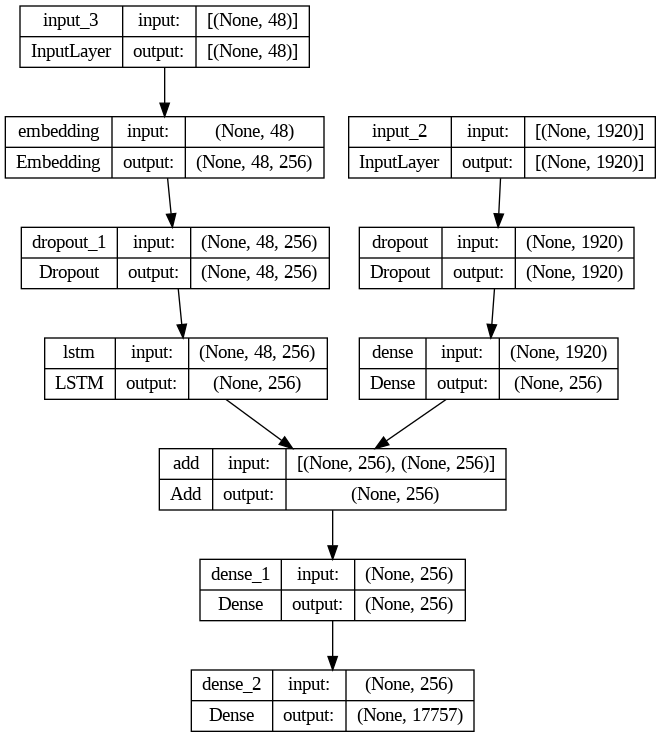

In [ ]:
# image feature layers
inputs1 = Input(shape = (1920,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation = 'relu')(fe1)

# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256 , mask_zero = True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation = 'relu')(decoder1)
outputs = Dense(vocab_size, activation = 'softmax')(decoder2)

# Merge 2 networks
model = Model(inputs= [inputs1, inputs2], outputs= outputs)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

#plot the model
plot_model(model, show_shapes= True)

In [ ]:
# model.layers[2].trainable = False

In [ ]:
# train the model
epochs = 15
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch = steps, verbose = 1)

227/227 [==============================] - 87s 382ms/step - loss: 3.1651


In [ ]:
# save the model
model.save(WORKING_DIR+'/densenet121.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [ ]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose = 0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        #append word as input for generating next word
        in_text += " "+word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

In [ ]:
from nltk.translate.bleu_score import corpus_bleu

# validate with text data
actual, predicted = list(), list()
for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)

# Calculate BLEU score
print("BLEU-1: %f" %corpus_bleu(actual, predicted, weights= (1.0, 0, 0, 0)))
print("BLEU-2: %f" %corpus_bleu(actual, predicted, weights= (0.5, 0.5, 0, 0)))
print("BLEU-3: %f" %corpus_bleu(actual, predicted, weights= (0.3, 0.3, 0.3, 0)))
print("BLEU-4: %f" %corpus_bleu(actual, predicted, weights= (0.25, 0.25, 0.25, 0.25)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.465044
BLEU-2: 0.261757
BLEU-3: 0.156166
BLEU-4: 0.059675


In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------------Actual--------------------------')
    for caption in captions:
        print(caption)
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------------Predicted------------------------')
    print(y_pred)
    plt.imshow(image)

---------------------------Actual--------------------------
startseq একটি কালো কুকুর এবং একটি ছোপওয়ালা কুকুর ঝগড়া করছে endseq
startseq একটি কালো কুকুর একটি তিন রঙা কুকুরের সাথে রাস্তায় খেলছে endseq
startseq একটি কালো কুকুর একটি সাদা-বাদামি ছোপযুক্ত কুকুর রাস্তায় একে অপরের দিকে তাকিয়ে আছে endseq
startseq ভিন্ন জাতের দুটি কুকুর রাস্তায় একে অপরের দিকে তাকিয়ে আছে endseq
startseq রাস্তার পাশে দুইটি কুকুর পরস্পরের দিকে এগিয়ে যাচ্ছ endseq
--------------------------Predicted------------------------
startseq একটি কুকুর একটি লাল রঙের বল নিয়ে খেলছে endseq


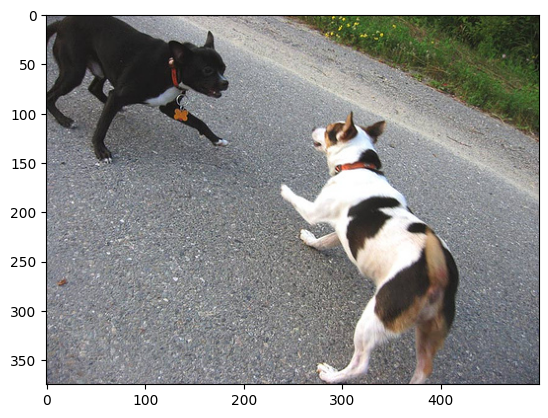

In [ ]:
generate_caption("1001773457_577c3a7d70.jpg")

---------------------------Actual--------------------------
startseq একজন পুরুষ টেবিলের উপর শুয়ে আছে যখন তার কুকুর তার পাশে বসে আছে endseq
startseq একজন মানুষ একটি বেঞ্চিতে শুয়ে আছে যার সাথে একটি সাদা কুকুরও বাধা আছে endseq
startseq একজন ব্যক্তি বাইরে বেঞ্চে ঘুমাচ্ছে এবং একটি সাদা কালো কুকুর তার পাশে বসে আছে endseq
startseq একজন নগ্নদেহী লোক তার পোষা কুকুরকে সাথে নিয়ে বাগানে একটি লম্বা আসনে শুয়ে আছে endseq
startseq মাটিতে বসে থাকা কুকুরটির শিকল ধরে বেঞ্চে শুয়ে আছে লোকটি endseq
--------------------------Predicted------------------------
startseq একটি ছোট ছেলে একটি আরভি এর বাইরে অলি করছে endseq


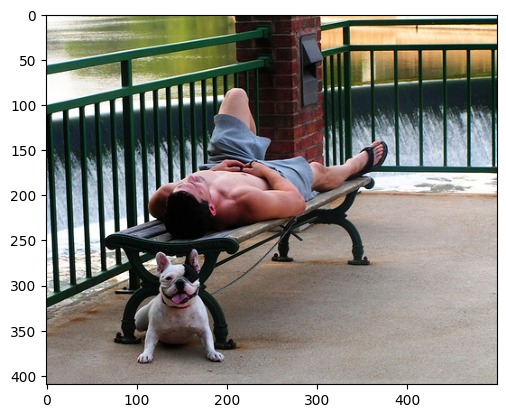

In [ ]:
generate_caption("1003163366_44323f5815.jpg")

---------------------------Actual--------------------------
startseq একটি কালো কুকুর একটি গাছের গুঁড়ির উপর দিয়ে লাফ দিচ্ছে endseq
startseq একটি ধূসর কুকুর ভেঙে পরা গাছের উপর দিয়ে লাফ দিয়ে যাচ্ছ endseq
startseq "একটি বড় কালো কুকুর একটি পতিত গাছের উপর দিয়ে লাফিয়ে যাচ্ছে" endseq
startseq নীল গলাবন্ধ পরিহিত কালো এবং ধূসর ছোপযুক্ত একটি কুকুর পড়ে থাকা একটি গাছের উপর দিয়ে লাফিয়ে যাচ্ছ endseq
startseq কালো কুকুরটি লাফিয়ে গাছের কুঁদা পার করছে endseq
--------------------------Predicted------------------------
startseq একটি কুকুর মুখে একটি খেলনা নিয়ে খেলছে endseq


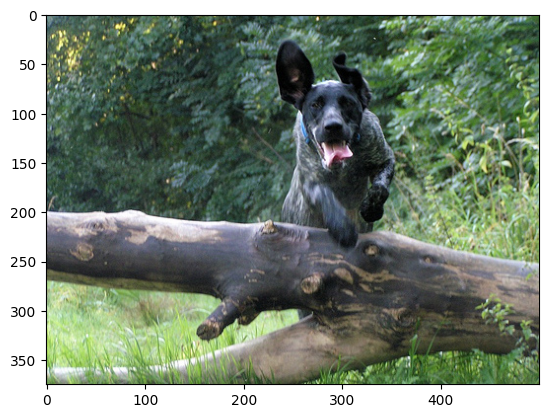

In [ ]:
generate_caption("1015584366_dfcec3c85a.jpg")

---------------------------Actual--------------------------
startseq "কাছাকাছি গাড়ি আছে এমন একটি মাঠে একটি কুকুর তার দিকে ছুঁড়ে দেয়া বস্তুটি ধরার প্রস্তুতি নিচ্ছে endseq
startseq একটি সাদা কুকুর একটি হলুদ বল তার মুখ দিয়ে ধরার চেষ্টা করছে endseq
startseq একটি সাদা কুকুর একটি হলুদ রঙের খেলনা ধরতে চলেছে endseq
startseq একটি সাদা কুকুর উড়তে থাকা একটি হলুদ বল ধরার জন্য প্রস্তুত endseq
startseq একটি সাদা কুকুর হলুদ বলের পিছনে দৌড়াচ্ছে endseq
--------------------------Predicted------------------------
startseq একটি কুকুর অদ্ভুতভাবে দৌড়াচ্ছে endseq


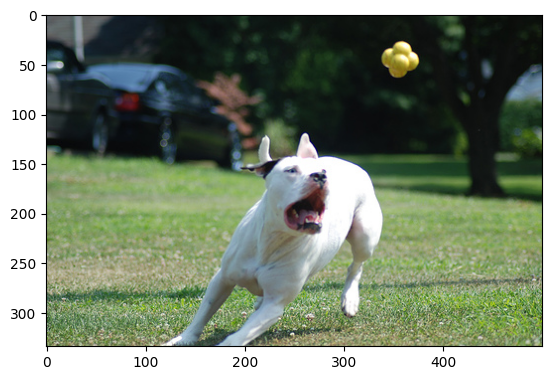

In [ ]:
generate_caption("1019604187_d087bf9a5f.jpg")

---------------------------Actual--------------------------
startseq কমলা টুপি পরিহিত একজন পুরুষ কোনোকিছুর দিকে তাকিয়ে আছে endseq
startseq একজন মানুষ কমলা রঙের টুপি পরেছ এবং চশমাও পরেছে endseq
startseq চশমাযুক্ত একজন ব্যক্তি একটি ব্লিটজ টুপি পরেছেন endseq
startseq চশমা পরিহিত একজন ব্যক্তি বিয়ারের কৌটা দিয়ে বানানো টুপি পরে আছে endseq
startseq কান ফোঁড়ানো ব্যক্তিটি চশমা এবং কমলা টুপি পরেছে endseq
--------------------------Predicted------------------------
startseq একটি ছোট ছেলে একটি লাল হেন্ডরেলে তার হাতটি ধরে আছে endseq


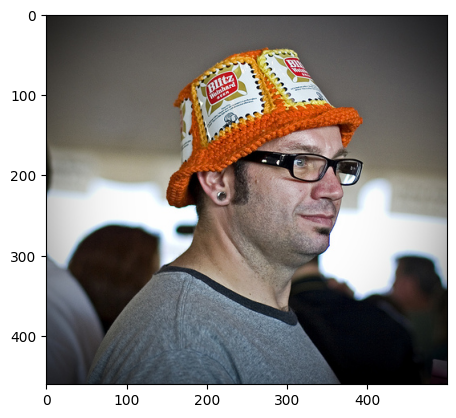

In [ ]:
generate_caption("1007129816_e794419615.jpg")


---------------------------Actual--------------------------
startseq একটি গোলাপী জামা পরা বাচ্চা মেয়ে একটি বাড়ির প্রবেশ পথের সিঁড়ি বেয়ে উঠছে endseq
startseq একটি মেয়ে শিশু একটি কাঠের বাড়িতে ঢুকছে endseq
startseq একটি বাচ্চা তার কাঠের খেলাঘরে উঠছে endseq
startseq ছোট মেয়েটি তার খেলার ঘরের সিড়ি বেয়ে উঠছে endseq
startseq গোলাপি জামা পড়া ছোট একটি মেয়ে একটি কাঠের তৈরি ঘরে প্রবেশ করছে endseq
--------------------------Predicted------------------------
startseq একটি ছোট ছেলে একটি পার্কে একটি বড় কুকুরকে গাইড করছে endseq


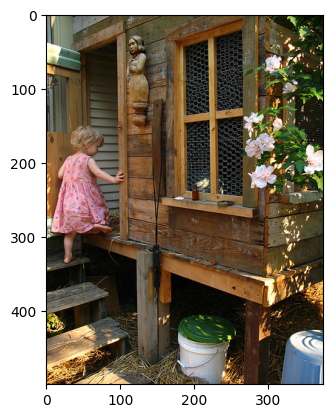

In [ ]:
generate_caption("1000268201_693b08cb0e.jpg")


---------------------------Actual--------------------------
startseq সাদা বেড়ি যুক্ত ঘাসে আবৃত একটি বাগানে একটি সাদা-কালো কুকুর দৌড়াচ্ছে endseq
startseq একটি সাদাকালো রঙের কুকুর ঘাসের উপর দৌড়াচ্ছে endseq
startseq ঘাসের উপর একটি বোস্টন টেরিয়ার কুকুর দৌড়াচ্ছে endseq
startseq একটি বোস্টন টেরিয়ার জাতের কুকুর সাদা বেড়ার সামনে দিয়ে ঘন সবুজ ঘাসের মধ্যে দৌড়ে যাচ্ছে endseq
startseq কাঠের বেড়ার পাশে কুকুরটি সবুজ ঘাসের উপর দৌড়াচ্ছে endseq
--------------------------Predicted------------------------
startseq একটি কুকুর একটি মাঠে খেলছে endseq


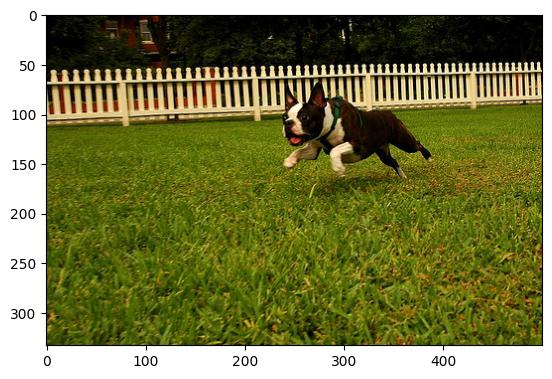

In [ ]:
generate_caption("1009434119_febe49276a.jpg")


---------------------------Actual--------------------------
startseq একটি শহরের একটি পাথর নির্মিত দেয়ালের সামনে একটি বালক হাসছে endseq
startseq একটি ছোট ছেলে রাস্তায় দাড়িয়ে আছে অ্যদিকে একজন লোক সবর্পরি কাজ করছে পাথরের দেওয়ালের উপর endseq
startseq একটি ছোট ছেলে রাস্তা দিয়ে দৌড়াচ্ছে endseq
startseq একটি ছোট শিশু পাথুরে রাস্তা ধরে হেঁটে যাচ্ছে এবং তার পেছনে একটি ধাতব খাম্বা এবং একজন ব্যক্তি রয়েছ endseq
startseq সাদা শার্ট আর নীল জিন্স পড়া হাস্যোজ্জ্বল ছেলেটি সম্পূর্ণ উল্টোদিকে মুখ করে থাকা লোকটির সাথে পাথুরে প্রাচীরের সামনে দাঁড়িয়ে আছে endseq
--------------------------Predicted------------------------
startseq একটি কুকুর মুখে একটি খেলনা নিয়ে খেলছে endseq


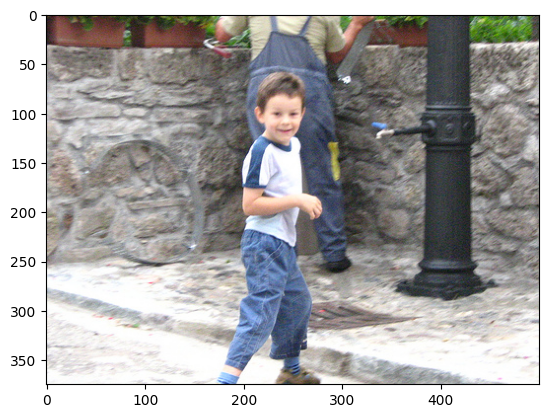

In [ ]:
generate_caption("1015118661_980735411b.jpg")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define the path where you want to save the model in Google Drive
save_path = '/content/drive/My Drive/ML models/resnet50_model.h5'

# Save the model
model.save(save_path)